# День добрый
___
### Представляю твоему вниманию проектную работу
## <ins>"Прогнозирование оттока клиентов из банка"</ins>
___
### Данное исследование разделим на несколько шагов:
___
<a id='top'></a>
1. [Постановка задачи](#1)
2. [Общая информация о данных](#2)
3. [Предобработка данных](#3)
4. [Подготовка признаков](#4)
5. [Несбалансированные данные](#5)
6. [Сбалансированные данные](#6)
7. [Тестирование](#7)
8. [Второй набор данных](#8)
9. [Вывод](#9)

<a id='1'></a>

## 1. Постановка задачи
Из «Бета-Банка» стали уходить клиенты. Банковские маркетологи считают, что сохранять текущих клиентов дешевле, чем привлекать новых.

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. У нас есть исторические данные о поведении клиентов и расторжении договоров с банком.

Построим модель с предельно большим значением F1-меры. Дополнительно измерим AUC-ROC и сравним её значение с F1-мерой.

<a id='2'></a>

## 2. Общая информация о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# прочитаем файл:

try:
    df = pd.read_csv("churn.csv")
except:
    try:
        df = pd.read_csv("/datasets/Churn.csv")
    except:
        df = pd.read_csv("https://code.s3.yandex.net/datasets/Churn.csv")
        
display(df.head())
print()
print(df.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


### Описание данных
**Признаки:**  
 * RowNumber — индекс строки в данных
 * CustomerId — уникальный идентификатор клиента
 * Surname — фамилия
 * CreditScore — кредитный рейтинг
 * Geography — страна проживания
 * Gender — пол
 * Age — возраст
 * Tenure — количество недвижимости у клиента
 * Balance — баланс на счёте
 * NumOfProducts — количество продуктов банка, используемых клиентом
 * HasCrCard — наличие кредитной карты
 * IsActiveMember — активность клиента
 * EstimatedSalary — предполагаемая зарплата
 
**Целевой признак:**  
 * Exited — факт ухода клиента

В таблице с исходными данными нам предоставлены сведения о клиентах. Есть несколько признаков, которые нам не понядобятся (первые 3 столбца), в столбце с количеством недвижимости у клиента есть пропуски (доля пропусков 9,1%).  
В следующем пункте решим что делать с пропусками и поищем аномалии в данных.

<a id='3'></a>

## 3. Предобработка данных<div align=right>[To top](#top)</div>

### Приведем названия признаков к нижнему регистру

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

### Проверка на отрицательные значения

In [4]:
for column_name in df.dtypes.index:
    
    if df[column_name].dtypes=='int64' or df[column_name].dtypes=='float64':
        
        if df[df[column_name] < 0][column_name].count() > 0:
            print('|{: <20}|{: >4}|'.format(column_name, 'Есть'))
        else:
            print('|{: <20}|{: >4}|'.format(column_name, 'Нет'))

|rownumber           | Нет|
|customerid          | Нет|
|creditscore         | Нет|
|age                 | Нет|
|tenure              | Нет|
|balance             | Нет|
|numofproducts       | Нет|
|hascrcard           | Нет|
|isactivemember      | Нет|
|estimatedsalary     | Нет|
|exited              | Нет|


### Проверка на дубликаты

In [5]:
df.duplicated().sum()

0

Дубликатов нет.

### Удалим ненужные признаки
Первые три столбца не несут никакой смысловой нагрузки для нашей задачи. Поэтому отбросим их.

In [6]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis=1)
df.head(2)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


### Обработка пропусков

Т.к. пропусков не настолько много, чтобы отбросить весь признак, надо решить как с ними поступать. Впринципе будет не критично если удалить все пропуски.

Я решил попробовать заполнить средним/медианой. А в конце работы попробовать удалить пропуски и сравнить какой метод тут был бы лучше.

Чтобы выбрать чем заполнять пропуски посмотрим на статистическое описание данного столбца:

In [7]:
# но сначала зарезервируем копию датасета для второго случая

df_delmissing = df.copy()

In [8]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Среднее и медиана практически равны. Возьмем медиану для ровного счета.

In [9]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


<a id='4'></a>

## 4. Подготовка признаков<div align=right>[To top](#top)</div>

### Построение распределений

Для того, чтобы модели работали, необходимо привести все признаки к числовому типу.  
У нас имеются два категориальных признака это `geography` и `gender`.

Для начала хотелось бы посмотреть как распределены наши признаки. Построим распределения с помощью гистограмм.  
Для этого нужно закодировать наши категориальные признаки.

При one-hot кодировании, для каждого значения признака  создаётся столбец, и в эти столбцы записывается ноль или единица в зависимости от того, какое значение признак имеет на этой строке. Новые признаки называются дамми-переменными, или **дамми-признаками** (англ. dummy variable, «фиктивная переменная»). При построении гистограмм этот метод не очень удобен, так как распределение категориального признака получается на нескольких изображениях, а хотелось бы видеть распределение одного признака на одном графике.

Поэтому для построения распределений используем простой кодировщик из библиотеки sklearn - **LabelEncoder()**. Он каждой категории сопоставляет некоторое целое число.

In [10]:
# сделаем копию датафрейма
df_hist = df.copy()

le = LabelEncoder()

# с помощью метода fit_transform сразу обучим и преобразуем наши признаки
df_hist['le_geo'] = le.fit_transform(df['geography'])
df_hist['le_gender'] = le.fit_transform(df['gender'])

# удалим теперь уже не нужные категориальные признаки
# предварительно заметив какое число какому значению присвоил кодировщик
df_hist = df_hist.drop(['geography', 'gender'], axis=1)

df_hist.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,le_geo,le_gender
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,2,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,2,0


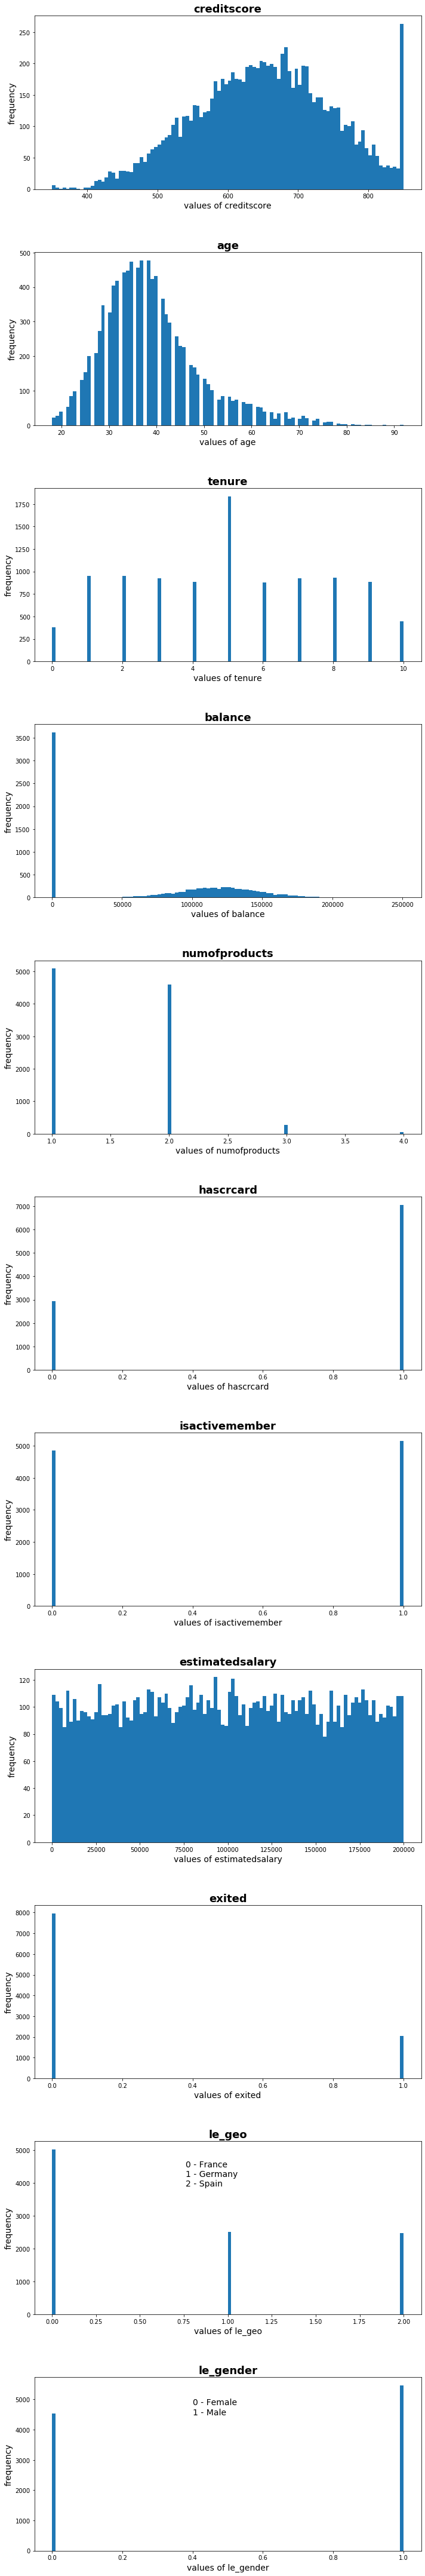

In [11]:
# строим распределения, всего у нас получилось 11 признаков

fig, subplots = plt.subplots(nrows=11, ncols=1, figsize=(10, 60))

columns = df_hist.columns
i = -1
for ax in fig.axes:
    i += 1
    ax.hist(df_hist[columns[i]], bins=100)
    
    ax.set_title(columns[i], fontsize=18, fontweight="bold")
    ax.set_xlabel('values of ' + columns[i], fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    
    # добавим на график обозначения кодировок
    if columns[i] == 'le_geo':
        ax.text(0.76, 3900, '0 - France\n1 - Germany\n2 - Spain', fontsize=14)
    elif columns[i] == 'le_gender':
        ax.text(0.4, 4500, '0 - Female\n1 - Male', fontsize=14)
            
plt.tight_layout(h_pad = 5)

Что можем сказать по этим распределениям:
 * Признаки `creditscore`, `age`, `tenure` и `balance` распределены боле-менее нормально. У `balance` много нулевых значений, выглядит подозрительно, но с другой стороны возможно правила банка не запрещают быть их клиентом и при этом не хранить деньги на счете. Такие клиенты могут пользоваться другими услугами банка. У `creditscore` тоже наблюдается резкий скачок значений при максимальном значении рейтинга.
 * Распределение признака`estimatedsalary` можно назвать скорее равномерным чем нормальным.
 * Большинство клиентов пользуются одной или двумя услугами банка.
 * Больше половины клиентов имеют кредитные карточки.
 * Активные и не активные клиенты делятся примерно поровну.
 * Факт ухода из банка зафиксирован у двух с небольшим тысяч клиентов. Налицо дисбаланс классов.
 * Клиенты из Франции составляют половину всех данных. Германия и Испания делят вторую половину данных пополам.
 * По половому признаку видим, что мужчин среди клиентов на одну тысячу больше чем женщин.

### Кодирование признаков для обучения и разделение данных

Чтобы закодировать признаки для обучения моделей применим one-hot кодирование описанное выше. При таком кодировании создаются отличные условия для мультиколлинеарности, т.к. вновь созданные признаки сильно коррелируют друг с другом. Чтобы минимизировать этот факт мы применим аргумент `drop_first=True`, который удаляет каждый первый столбец из группы вновь созданных признаков.

In [12]:
df = pd.get_dummies(df, drop_first=True)
df.head(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0



Перед масштабированием признаков необходимо разделить данные на обучающую, валидационную и тестовую выборки. Сделаем это с помощью функции **train_test_split** из библиотеки sklearn. Данные разделим в соотношении 60:20:20.

In [13]:
# сначала делаим на обучающую и проверочную
df_train, df_check = train_test_split(df, test_size=0.4, random_state=237)

# далее проверочную разделим на валидационную и тестовую
df_valid, df_test = train_test_split(df_check, test_size=0.5, random_state=237)

In [14]:
# контроль размера выборок

print('train', df_train.shape)
print('valid', df_valid.shape)
print('test', df_test.shape)

train (6000, 12)
valid (2000, 12)
test (2000, 12)


Объявим новые переменные `features` и `target`, в которых будут признаки и целевой признак соответственно:

In [15]:
# признаки
features_train = df_train.drop('exited', axis=1)
features_valid = df_valid.drop('exited', axis=1)
features_test = df_test.drop('exited', axis=1)

# целевые признаки
target_train = df_train['exited']
target_valid = df_valid['exited']
target_test = df_test['exited']

### Масштабирование признаков
Чтобы у модели не было "любимчиков" среди признаков, т.е. чтобы она учитывала все признаки как важные, необходимо масштабировать признаки. Тогда числа в признаках будут иметь диапазон значений от -1 до 1 со средним равным нулю.  
Распределения большей части наших признаков приближены к нормальному. Поэтому для масштабирования применим стандартизацию, которая хорошо работает с данными распределенными нормально, и хуже, но все таки работает, масштабирует данные с ненормальным распределением.

Для этого в библиотеке sklearn усть функция **StandardScaler()**. Обучим ее на обучающей выборке и затем трансформируем остальные.

In [16]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']

In [17]:
# создадим объект этой структуры
scaler = StandardScaler()

# настроим его на обучающих данных
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
# преобразуем выборки методом transform()

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<a id='5'></a>

## 5. Несбалансированные данные<div align=right>[To top](#top)</div>

Как раньше мы уже выяснили у нас наблюдается дисбаланс классов целевого признака:

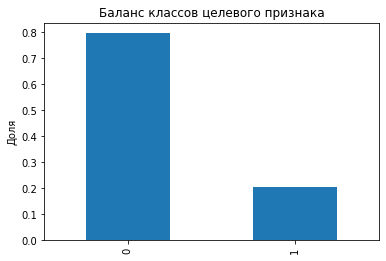

In [19]:
class_frequency = df['exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar', title='Баланс классов целевого признака')
plt.ylabel('Доля')

plt.show()

Всего около 20% положительных ответов.

Попробуем сначала обучить модели сохранив этот дисбаланс и посмотрим что покажет нам метрика.

В качестве метрики будем использовать **F1-меру**. F1-мера это агрегирующая метрика, которая помогает контролировать параллельно две другие метрики, такие как полнота и точность (recall и precision).

### Решающее дерево

In [20]:
# nb - not balanced

f1_tree_nb_list = []

for md_tree_nb in range(2, 16):
    model_tree_nb = DecisionTreeClassifier(max_depth=md_tree_nb, random_state=237)
    model_tree_nb.fit(features_train, target_train)
    predictions_tree_nb = model_tree_nb.predict(features_valid)
    
    f1_tree_nb = round(f1_score(target_valid, predictions_tree_nb), 4)
    
    f1_tree_nb_list.append(f1_tree_nb)
    
print('Максимальное F1', max(f1_tree_nb_list), 'при max_depth =', np.argmax(f1_tree_nb_list)+2)

Максимальное F1 0.5872 при max_depth = 7


### Случайный лес

Разобьем рассчеты на два этапа чтобы съэкономить время:
 1. Сначала переберем в цикле максимальную глубину при количестве деревьев равным 20.
 2. На втором шаге глубину дерева, показавшую наилучший результат, зафиксируем и при этой глубине переберем количество деревьев.

In [21]:
# rf - random forest

f1_rf_nb_list = []
for md_rf_nb in range(2, 21):
    model_rf_nb = RandomForestClassifier(n_estimators=20, max_depth=md_rf_nb, random_state=237)
    model_rf_nb.fit(features_train, target_train)
    prediction_rf_nb = model_rf_nb.predict(features_valid)
    
    f1_rf_nb = round(f1_score(target_valid, prediction_rf_nb), 4)
    
    f1_rf_nb_list.append(f1_rf_nb)
    
max_depth1 = np.argmax(f1_rf_nb_list)+2
    
f1_rf_nb_list_ne = []
for ne_rf_nb in range(2, 151):
    model_rf_nb_ne = RandomForestClassifier(max_depth=max_depth1, n_estimators=ne_rf_nb, random_state=237)
    model_rf_nb_ne.fit(features_train, target_train)
    prediction_rf_nb_ne = model_rf_nb_ne.predict(features_valid)
    
    f1_rf_nb_ne = round(f1_score(target_valid, prediction_rf_nb_ne), 4)
    f1_rf_nb_list_ne.append(f1_rf_nb_ne)

print('Максимальное F1', max(f1_rf_nb_list_ne), 'при max_depth =', max_depth1,
      'и n_estimators =', np.argmax(f1_rf_nb_list_ne)+2)

Максимальное F1 0.6075 при max_depth = 20 и n_estimators = 25


### Логистическая регрессия

In [22]:
# lr - logistic regression

model_lr_nb = LogisticRegression(random_state=237, solver='lbfgs')
model_lr_nb.fit(features_train, target_train)
prediction_lr_nb = model_lr_nb.predict(features_valid)

f1_lr_nb = round(f1_score(target_valid, prediction_lr_nb), 4)

print('F1', f1_lr_nb)

F1 0.3091


Лучший результат у модели "Случайный лес": F1-мера равна 0,6075. Но без проверки модели на адекватность нельзя сказать насколько полученный нами результат хорош.

Выполним проверку путем создания константной модели, которая каждому объекту предсказывает единицу.

In [23]:
target_pred_constant = pd.Series(data=1, index=range(0, len(target_valid)))

f1_target_pred_constant = round(f1_score(target_valid, target_pred_constant), 4)
print(f1_target_pred_constant)

0.3382


Т.к. положительных ответов в target_valid немного, то, соответственно, и пороговая F1-мера невысокая. Но мы видим, что лигстической регрессии значение F1-меры ниже пороговой.

<a id='6'></a>

## 6. Cбалансированные данные<div align=right>[To top](#top)</div>

### Логистическая регрессия

Попробуем улучшить качетсво логистической регрессии и остальных моделей учитывая дисбаланс классов в целевом признаке.

Чтобы сделать объекты редкого класса не такими редкими воспользуемся техникой **upsampling**. Смысл техники в том, чтобы увеличить долю редкого класса в выборке путем его копирования.

Т.к. в нашей выборке редким классом являются положительные ответы, то их и будем копировать.  
Преобразование проходит в несколько этапов:
 * Разделить обучающую выборку на отрицательные и положительные объекты;
 * Скопировать несколько раз положительные объекты;
 * С учётом полученных данных создать новую обучающую выборку;
 * Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

Напишем функцию, которая выполнит все этапы преобразования.

In [24]:
# объявляем функцию
def upsample(features, target, repeat):# repeat - это количество копий редкого класса, которые нужно добавить
    
    # делим выборку на отрицательные и положительные объекты
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    # при помощи функции concat из библиотеки pandas объеденим второй и третий пункты преобразования
    features_upsampling = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampling = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем вновь созданные выборки при помощи функции shuffle из библиотеки sklearn
    features_upsampling, target_upsampling = shuffle(features_upsampling, target_upsampling, random_state=237)
    
    return features_upsampling, target_upsampling

In [25]:
# преобразуем наши обучающие выборки

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

**Я пробовал разные соотношения классов, но при repeat=3 получается лучшее качество**

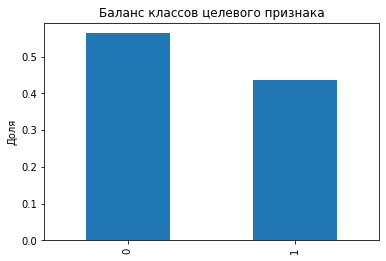

In [26]:
# проверим что получилось используя график

class_frequency_target_upsampled = target_upsampled.value_counts(normalize=True)
class_frequency_target_upsampled.plot(kind='bar', title='Баланс классов целевого признака')
plt.ylabel('Доля')

plt.show()

In [27]:
class_frequency_target_upsampled

0    0.563327
1    0.436673
Name: exited, dtype: float64

Теперь доли каждого класса более сбалансированны.

Попробуем обучить модель регрессии на этих данных и посмотрим как изменится ее качество после этих нововведений.

In [28]:
# b - balanced

model_lr_b = LogisticRegression(random_state=237, solver='lbfgs')
model_lr_b.fit(features_upsampled, target_upsampled)
prediction_lr_b = model_lr_b.predict(features_valid)

f1_lr_b = round(f1_score(target_valid, prediction_lr_b), 4)

print(f1_lr_b)

0.4933


Как можно заметить качество модели заметно повысилось после применения техники upsampling():

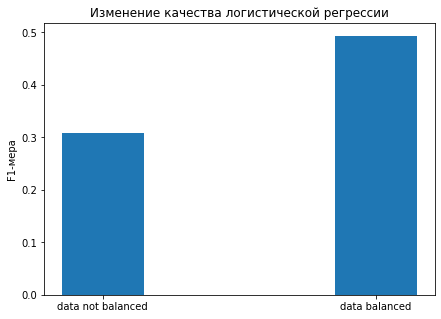

In [29]:
x = [1, 2]
y_lr_nb_b = [f1_lr_nb, f1_lr_b]

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(x, y_lr_nb_b, width=0.3, tick_label=['data not balanced', 'data balanced'])

ax.set_title('Изменение качества логистической регрессии')
ax.set_ylabel('F1-мера')

plt.show()

Попробуем ввести еще одну метрику для проверки качества модели - **AUC-ROC**.

Она определяется как площадь под кривой ROC, построенной по значениям  TPR и FPR. TPR и FPR это доли истинно положительных и ложно положительных ответов соответственно.

ROC-кривая показывает зависимость TPR от FPR при варьировании порога классификации. Если представить, что модель с определенной вероятностью предсказывает нули и единицы, то если, например, увеличить вероятность предсказания единицы => будем получать больше единиц и меньше нулей. Варьирование порога классификации - это и есть изменение вероятности предсказания того или иного класса.

Порог классификации изменяется от 0 до 1. По умолчанию порог равен 0,5. Посмотреть вероятности классов объектов можно с помощью функции predict_proba():

In [30]:
probabilities_valid_lr_b = model_lr_b.predict_proba(features_valid)

# просмотрим первые 5
probabilities_valid_lr_b[:5]

array([[0.81370979, 0.18629021],
       [0.27347494, 0.72652506],
       [0.79900533, 0.20099467],
       [0.81337582, 0.18662418],
       [0.68429453, 0.31570547]])

Если изменить порог в меньшую сторону, то модель повысит вероятность принадлежности объекта к классу 1 и наоборот.

Попробуем построить кривую ошибок для нашей модели. Построить ROC-кривую поможет функция roc_curve(). На вход она принимает значения целевого признака и вероятности положительного класса. Перебирает разные пороги и возвращает три списка: значения FPR, значения TPR и рассмотренные пороги.

In [31]:
probabilities_one_valid_lr_b = probabilities_valid_lr_b[:, 1]

# просмотрим первые 5
probabilities_one_valid_lr_b[:5]

array([0.18629021, 0.72652506, 0.20099467, 0.18662418, 0.31570547])

In [32]:
# определяем переменные

fpr_lr_b, tpr_lr_b, thresholds_lr_b = roc_curve(target_valid, probabilities_one_valid_lr_b)

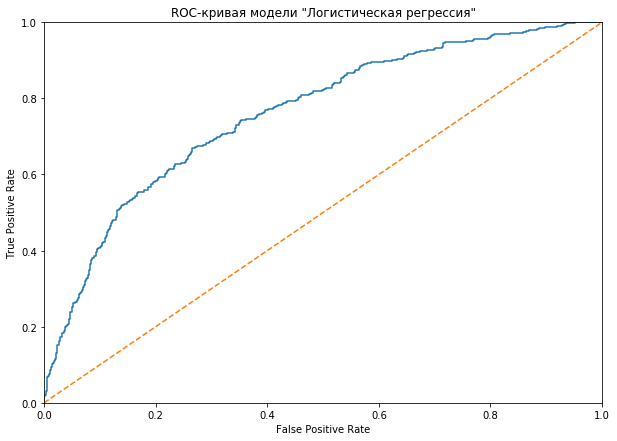

In [33]:
# строим ROC-кривую

plt.figure(figsize=(10, 7))

# ROC-кривая нашей модели
plt.plot(fpr_lr_b, tpr_lr_b, '-')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая модели "Логистическая регрессия"')

plt.show()

На графике оранжевая пунктирная линия соответствует предсказаниям случайной модели. Площадь под этой прямой равно 0,5. Соответственно, чтобы наша модель была адекватной, нужно чтобы ее график проходил над прямой случайной модели, т.е. чтобы площадь под кривой была болшье 0,5.

Она проходит из точки (0,0), соответствующей максимальному значению порога, в точку (1,1), соответствующую минимальному значению порога.  
Кривая модели монотонно не убывает. Чем выше лежит кривая, тем лучше качество классификации.

Площадь под ROC-кривой AUC (Area Under Curve) является агрегированной характеристикой качества классификации. Чем больше значение AUC, тем лучше модель классификации. Данный показатель часто используется для сравнительного анализа нескольких моделей классификации.  
Вычисляется площадь под кривой при помощи метрики **roc_auc_score** из библиотеки sklearn. На вход она принимает значения целевого признака и вероятности положительного класса, возвращает значение площади под кривой.

In [34]:
auc_roc_lr_b = round(roc_auc_score(target_valid, probabilities_one_valid_lr_b), 4)
auc_roc_lr_b

0.7608

Получили значение площади под кривой на четверть выше, чем у случайной модели. Уже неплохо.

Поскольку техника upsampling показала, что работает на благо нашей задаче, то попробуем обучить остальные модели на новых выборках и посчитать две новых метрики для каждой.

### Решающее дерево

In [35]:
f1_tree_b_list = []
auc_roc_tree_b_list = []

for md_tree_b in range(2, 20):
    model_tree_b = DecisionTreeClassifier(max_depth=md_tree_b, random_state=237)
    model_tree_b.fit(features_upsampled, target_upsampled)
    predictions_tree_b = model_tree_b.predict(features_valid)
    
    f1_tree_b = round(f1_score(target_valid, predictions_tree_b), 4)
    f1_tree_b_list.append(f1_tree_b)
    
    probabilities_valid_tree_b = model_tree_b.predict_proba(features_valid)
    probabilities_one_valid_tree_b = probabilities_valid_tree_b[:, 1]
    auc_roc_tree_b = round(roc_auc_score(target_valid, probabilities_one_valid_tree_b), 4)
    auc_roc_tree_b_list.append(auc_roc_tree_b)

print('Максимальное F1', max(f1_tree_b_list), 'при max_depth =', np.argmax(f1_tree_b_list)+2)
print()
print('Максимальное AUC-ROC', max(auc_roc_tree_b_list), 'при max_depth =', np.argmax(auc_roc_tree_b_list)+2)

Максимальное F1 0.5998 при max_depth = 7

Максимальное AUC-ROC 0.8358 при max_depth = 5


### Случайный лес

In [36]:
%%time

f1_rf_b_list = []
for md_rf_b in range(2, 21):
    
    model_rf_b = RandomForestClassifier(max_depth=md_rf_b, n_estimators=20, random_state=237)
    model_rf_b.fit(features_upsampled, target_upsampled)
    prediction_rf_b = model_rf_b.predict(features_valid)
    
    f1_rf_b = round(f1_score(target_valid, prediction_rf_b), 4)
    f1_rf_b_list.append(f1_rf_b)
    
max_depth2 = np.argmax(f1_rf_b_list)+2


f1_rf_b_list_ne = []
auc_roc_rf_b_list_ne = []

for ne_rf_b in range(2, 151):
    
    model_rf_b_ne = RandomForestClassifier(max_depth=max_depth2, n_estimators=ne_rf_b, random_state=237)
    model_rf_b_ne.fit(features_upsampled, target_upsampled)
    prediction_rf_b_ne = model_rf_b_ne.predict(features_valid)
    
    f1_rf_b_ne = round(f1_score(target_valid, prediction_rf_b_ne), 4)
    f1_rf_b_list_ne.append(f1_rf_b_ne)
    
    probabilities_valid_rf_b_ne = model_rf_b_ne.predict_proba(features_valid)
    probabilities_one_valid_rf_b_ne = probabilities_valid_rf_b_ne[:, 1]
    auc_roc_rf_b_ne = round(roc_auc_score(target_valid, probabilities_one_valid_rf_b_ne), 4)
    auc_roc_rf_b_list_ne.append(auc_roc_rf_b_ne)
    
print('Максимальное F1', max(f1_rf_b_list_ne), 'при max_depth =', max_depth2, 'и n_estimators =', np.argmax(f1_rf_b_list_ne)+2)
print()
print('Максимальное AUC-ROC', max(auc_roc_rf_b_list_ne),
      'при max_depth =', max_depth2, 'и n_estimators =', np.argmax(auc_roc_rf_b_list_ne)+2)

# перменная для тестирования
n_estim = np.argmax(auc_roc_rf_b_list_ne)+2

Максимальное F1 0.6524 при max_depth = 12 и n_estimators = 100

Максимальное AUC-ROC 0.86 при max_depth = 12 и n_estimators = 144
CPU times: user 2min 18s, sys: 282 ms, total: 2min 18s
Wall time: 2min 20s


Посмотрим на графиках как изменилась метрика F1 в сравнени с несбалансированным данными:

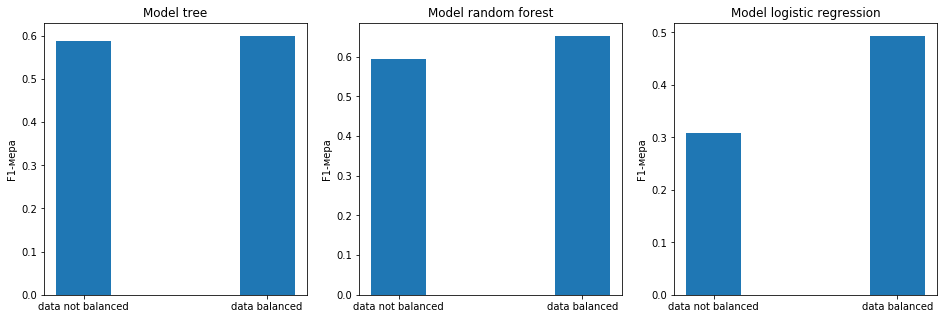

In [37]:
x = [1, 2]

y_tree = [max(f1_tree_nb_list), max(f1_tree_b_list)]
y_rf = [max(f1_rf_nb_list), max(f1_rf_b_list_ne)]
y_lr = [f1_lr_nb, f1_lr_b]

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].bar(x, y_tree, width=0.3, tick_label=['data not balanced', 'data balanced'])
ax[0].set_title('Model tree')
ax[0].set_ylabel('F1-мера')

ax[1].bar(x, y_rf, width=0.3, tick_label=['data not balanced', 'data balanced'])
ax[1].set_title('Model random forest')
ax[1].set_ylabel('F1-мера')

ax[2].bar(x, y_lr, width=0.3, tick_label=['data not balanced', 'data balanced'])
ax[2].set_title('Model logistic regression')
ax[2].set_ylabel('F1-мера')

plt.show()

У моделей "Решающее дерево" и "Случайный лес" небольшой прирост в метрике. "Логистическая регрессия" значительно прибавила в качестве.

Следовательно "деревянные" модели слабо зависят от дисбаланса классов.

**Наилучшая F1-мера у модели "Случайный лес" с результатом 0,6524**

Попробуем построить ROC-кривые для всех моделей:

In [38]:
# определяем переменные двух оставшихся моделей (для логистической регрессии уже есть)

fpr_tree_b, tpr_tree_b, thresholds_tree_b = roc_curve(target_valid, probabilities_one_valid_tree_b)
fpr_rf_b, tpr_rf_b, thresholds_rf_b = roc_curve(target_valid, probabilities_one_valid_rf_b_ne)

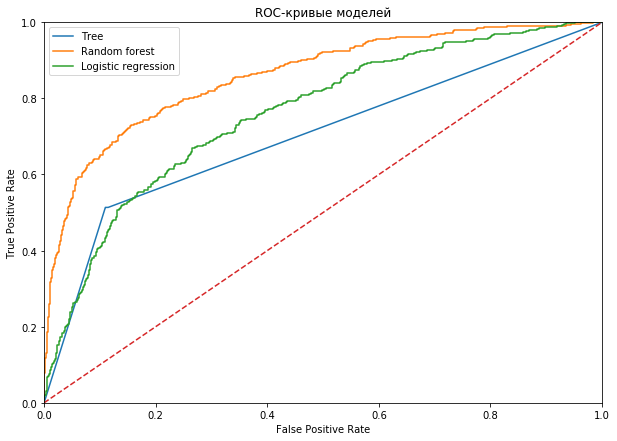

In [39]:
plt.figure(figsize=(10, 7))

# ROC-кривая наших моделей
plt.plot(fpr_tree_b, tpr_tree_b, '-', label='Tree')
plt.plot(fpr_rf_b, tpr_rf_b, '-', label='Random forest')
plt.plot(fpr_lr_b, tpr_lr_b, '-', label='Logistic regression')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривые моделей')

plt.legend()

plt.show()

Как видно из графика ROC-кривых наибольшая площадь под кривой также у **модели "Случайный лес" с результатом AUC-ROC = 0,86**

Также можно заметить, что дерево решений ведет себя странно и больше похожа на случайную модель.

<a id='7'></a>

## 7. Тестирование<div align=right>[To top](#top)</div>

In [40]:
model_rf_b_test = RandomForestClassifier(max_depth=max_depth2, n_estimators=n_estim, random_state=237)
model_rf_b_test.fit(features_upsampled, target_upsampled)
predictions_rf_b_test = model_rf_b_test.predict(features_test)

f1_rf_b_test = round(f1_score(target_test, predictions_rf_b_test), 4)
print('F1-мера на тестовой выборке', f1_rf_b_test)
print()

probabilities_valid_rf_b_test = model_rf_b_test.predict_proba(features_test)
probabilities_one_valid_rf_b_test = probabilities_valid_rf_b_test[:, 1]
auc_roc_rf_b_test = round(roc_auc_score(target_test, probabilities_one_valid_rf_b_test), 4)
print('AUC-ROC на тестовой выборке', auc_roc_rf_b_test)

F1-мера на тестовой выборке 0.6108

AUC-ROC на тестовой выборке 0.8689


Получили значение F1-меры на тестовой выборке 0,61, что немного выше минимального порога по заданию.

<a id='8'></a>

## 8. Второй набор данных<div align=right>[To top](#top)</div>

Проделаем тоже самое со вторым набором данных, в которых пропуски удалены и посмотрим отличия в качестве моделей.

### Удаление пропусков

In [41]:
# зарезервированный датасет

df_delmissing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [42]:
# удаляем пропуски

df_delmissing = df_delmissing.dropna()
df_delmissing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
creditscore        9091 non-null int64
geography          9091 non-null object
gender             9091 non-null object
age                9091 non-null int64
tenure             9091 non-null float64
balance            9091 non-null float64
numofproducts      9091 non-null int64
hascrcard          9091 non-null int64
isactivemember     9091 non-null int64
estimatedsalary    9091 non-null float64
exited             9091 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


### Кодирование признаков и разделение данных

In [43]:
# one-hot кодирование

df_delmissing = pd.get_dummies(df_delmissing, drop_first=True)
df_delmissing.head(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0


In [44]:
# разделение данных на обучающую, валидационную и тестовую выборки

df_delmissing_train, df_delmissing_check = train_test_split(df_delmissing, test_size=0.4, random_state=237)

df_delmissing_valid, df_delmissing_test = train_test_split(df_delmissing_check, test_size=0.5, random_state=237)

print('train', df_delmissing_train.shape)
print('valid', df_delmissing_valid.shape)
print('test', df_delmissing_test.shape)

train (5454, 12)
valid (1818, 12)
test (1819, 12)


In [45]:
# деление выборок на признаки и цели

features_train_dm = df_delmissing_train.drop('exited', axis=1)
features_valid_dm = df_delmissing_valid.drop('exited', axis=1)
features_test_dm = df_delmissing_test.drop('exited', axis=1)

target_train_dm = df_delmissing_train['exited']
target_valid_dm = df_delmissing_valid['exited']
target_test_dm = df_delmissing_test['exited']

### Масштабирование признаков

In [46]:
scaler_dm = StandardScaler()

In [47]:
scaler_dm.fit(features_train_dm[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [48]:
features_train_dm[numeric] = scaler_dm.transform(features_train_dm[numeric])
features_valid_dm[numeric] = scaler_dm.transform(features_valid_dm[numeric])
features_test_dm[numeric] = scaler_dm.transform(features_test_dm[numeric])

### Баланс классов

Т.к. техника upsampling в целом плодотворно повлияла на модели, то сразу преобразуем данные.

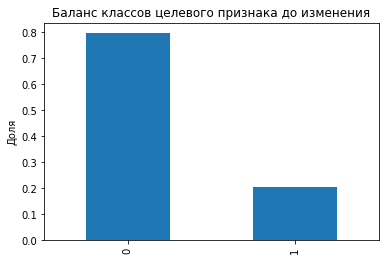

In [49]:
# dm - del missing

class_frequency_dm = df_delmissing['exited'].value_counts(normalize=True)
class_frequency_dm.plot(kind='bar', title='Баланс классов целевого признака до изменения')
plt.ylabel('Доля')

plt.show()

Преобразовываем через уже известную нам функцию `upsample`

In [50]:
# преобразуем наши обучающие выборки

features_upsampled_dm, target_upsampled_dm = upsample(features_train_dm, target_train_dm, 3)

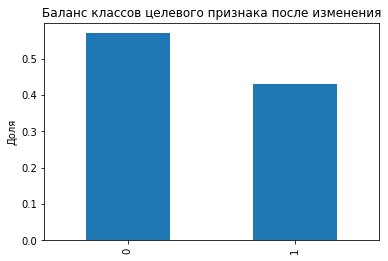

In [51]:
class_frequency_dm2 = target_upsampled_dm.value_counts(normalize=True)
class_frequency_dm2.plot(kind='bar', title='Баланс классов целевого признака после изменения')
plt.ylabel('Доля')

plt.show()

### Обучение моделей

Аналогично обучим те же модели и вычислим метрики.

#### Решающее дерево

In [52]:
f1_tree_b_dm_list = []
auc_roc_tree_b_dm_list = []

for md_tree_b_dm in range(2, 20):
    model_tree_b_dm = DecisionTreeClassifier(max_depth=md_tree_b_dm, random_state=237)
    model_tree_b_dm.fit(features_upsampled_dm, target_upsampled_dm)
    predictions_tree_b_dm = model_tree_b_dm.predict(features_valid_dm)
    
    f1_tree_b_dm = round(f1_score(target_valid_dm, predictions_tree_b_dm), 4)
    f1_tree_b_dm_list.append(f1_tree_b_dm)
    
    probabilities_valid_tree_b_dm = model_tree_b_dm.predict_proba(features_valid_dm)
    probabilities_one_valid_tree_b_dm = probabilities_valid_tree_b_dm[:, 1]
    auc_roc_tree_b_dm = round(roc_auc_score(target_valid_dm, probabilities_one_valid_tree_b_dm), 4)
    auc_roc_tree_b_dm_list.append(auc_roc_tree_b_dm)
    
print(f1_tree_b_dm_list)
print()
print('Максимальное F1', max(f1_tree_b_dm_list), 'при max_depth =', np.argmax(f1_tree_b_dm_list)+2)
print()
print('Максимальное AUC-ROC', max(auc_roc_tree_b_dm_list), 'при max_depth =', np.argmax(auc_roc_tree_b_dm_list)+2)

[0.5038, 0.5, 0.524, 0.5606, 0.5662, 0.5763, 0.5795, 0.5607, 0.5416, 0.5335, 0.5234, 0.5235, 0.5115, 0.5033, 0.5235, 0.5131, 0.493, 0.512]

Максимальное F1 0.5795 при max_depth = 8

Максимальное AUC-ROC 0.8377 при max_depth = 5


#### Случайный лес

In [53]:
f1_rf_b_dm_list = []

for md_rf_b_dm in range(2, 20):
    
    model_rf_b_dm = RandomForestClassifier(max_depth=md_rf_b_dm, n_estimators=20, random_state=237)
    model_rf_b_dm.fit(features_upsampled_dm, target_upsampled_dm)
    prediction_rf_b_dm = model_rf_b_dm.predict(features_valid_dm)
    
    f1_rf_b_dm = round(f1_score(target_valid_dm, prediction_rf_b_dm), 4)
    f1_rf_b_dm_list.append(f1_rf_b_dm)

max_depth3 = np.argmax(f1_rf_b_dm_list)

f1_rf_b_dm_list_ne = []
auc_roc_rf_b_dm_list_ne = []

for ne_rf_b_dm in range(2, 151):
    
    model_rf_b_ne_dm = RandomForestClassifier(max_depth=max_depth3, n_estimators=ne_rf_b_dm, random_state=237)
    model_rf_b_ne_dm.fit(features_upsampled_dm, target_upsampled_dm)
    prediction_rf_b_ne_dm = model_rf_b_ne_dm.predict(features_valid_dm)
    
    f1_rf_b_ne_dm = round(f1_score(target_valid_dm, prediction_rf_b_ne_dm), 4)
    f1_rf_b_dm_list_ne.append(f1_rf_b_ne_dm)
    
    probabilities_valid_rf_b_ne_dm = model_rf_b_ne_dm.predict_proba(features_valid_dm)
    probabilities_one_valid_rf_b_ne_dm = probabilities_valid_rf_b_ne_dm[:, 1]
    auc_roc_rf_b_ne_dm = round(roc_auc_score(target_valid_dm, probabilities_one_valid_rf_b_ne_dm), 4)
    auc_roc_rf_b_dm_list_ne.append(auc_roc_rf_b_ne_dm)
    
print('Максимальное F1', max(f1_rf_b_dm_list_ne), 'при max_depth =', max_depth3,
      'и n_estimators =', np.argmax(f1_rf_b_dm_list_ne)+2)
print()
print('Максимальное AUC-ROC', max(auc_roc_rf_b_dm_list_ne),'при max_depth =', max_depth3,
      'и n_estimators =', np.argmax(auc_roc_rf_b_dm_list_ne)+2)

# переменная для тестирования
n_estim_dm = np.argmax(auc_roc_rf_b_dm_list_ne)+2

Максимальное F1 0.611 при max_depth = 7 и n_estimators = 61

Максимальное AUC-ROC 0.8555 при max_depth = 7 и n_estimators = 46


#### Логистическая регрессия

In [54]:
model_lr_b_dm = LogisticRegression(random_state=237, solver='lbfgs')
model_lr_b_dm.fit(features_upsampled_dm, target_upsampled_dm)
prediction_lr_b_dm = model_lr_b_dm.predict(features_valid_dm)

f1_lr_b_dm = round(f1_score(target_valid_dm, prediction_lr_b_dm), 4)

probabilities_valid_lr_b_dm = model_lr_b_dm.predict_proba(features_valid_dm)
probabilities_one_valid_lr_b_dm = probabilities_valid_lr_b_dm[:, 1]
auc_roc_lr_b_dm = round(roc_auc_score(target_valid_dm, probabilities_one_valid_lr_b_dm), 4)

print('F1-мера', f1_lr_b_dm)
print()
print('AUC-ROC', auc_roc_lr_b_dm)

F1-мера 0.4588

AUC-ROC 0.7541


### Тестирование

In [55]:
model_rf_b_test_dm = RandomForestClassifier(max_depth=max_depth3, n_estimators=n_estim_dm, random_state=237)
model_rf_b_test_dm.fit(features_upsampled_dm, target_upsampled_dm)
predictions_rf_b_test_dm = model_rf_b_test_dm.predict(features_test_dm)

f1_rf_b_test_dm = round(f1_score(target_test_dm, predictions_rf_b_test_dm), 4)
print('F1-мера на тестовой выборке', f1_rf_b_test_dm)
print()

probabilities_valid_rf_b_test_dm = model_rf_b_test_dm.predict_proba(features_test_dm)
probabilities_one_valid_rf_b_test_dm = probabilities_valid_rf_b_test_dm[:, 1]
auc_roc_rf_b_test_dm = round(roc_auc_score(target_test_dm, probabilities_one_valid_rf_b_test_dm), 4)
print('AUC-ROC на тестовой выборке', auc_roc_rf_b_test_dm)

F1-мера на тестовой выборке 0.6397

AUC-ROC на тестовой выборке 0.8692


На три сотых выше, чем с предыдущими данными.

Сравним результаты метрик разных моделей с разных данных на графиках:

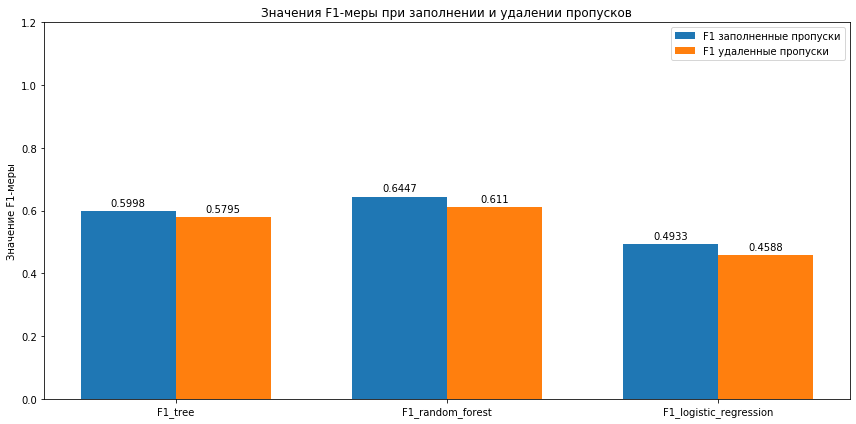

In [56]:
labels = ['F1_tree', 'F1_random_forest', 'F1_logistic_regression']

f1_wm = [max(f1_tree_b_list), max(f1_rf_b_list), f1_lr_b]
f1_dm = [max(f1_tree_b_dm_list), max(f1_rf_b_dm_list_ne), f1_lr_b_dm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, f1_wm, width, label='F1 заполненные пропуски')
rects2 = ax.bar(x + width/2, f1_dm, width, label='F1 удаленные пропуски')

ax.set_ylabel('Значение F1-меры')
ax.set_ylim(0, 1.2)
ax.set_title('Значения F1-меры при заполнении и удалении пропусков')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

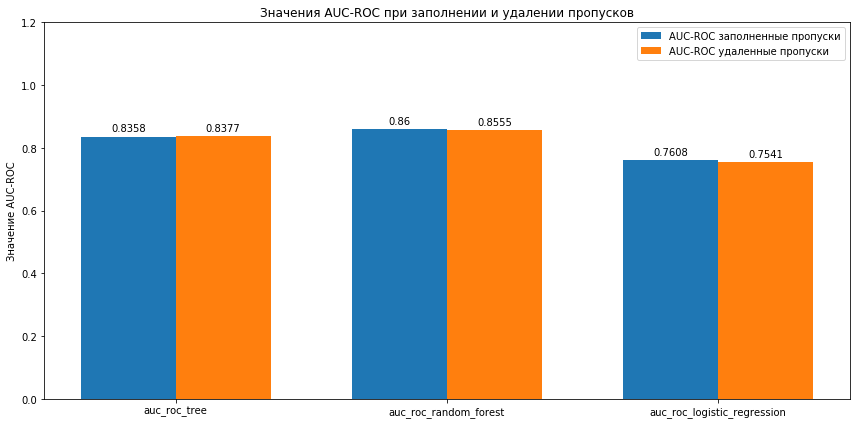

In [57]:
labels = ['auc_roc_tree', 'auc_roc_random_forest', 'auc_roc_logistic_regression']

ar_wm = [max(auc_roc_tree_b_list), max(auc_roc_rf_b_list_ne), auc_roc_lr_b]
ar_dm = [max(auc_roc_tree_b_dm_list), max(auc_roc_rf_b_dm_list_ne), auc_roc_lr_b_dm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, ar_wm, width, label='AUC-ROC заполненные пропуски')
rects2 = ax.bar(x + width/2, ar_dm, width, label='AUC-ROC удаленные пропуски')

ax.set_ylabel('Значение AUC-ROC')
ax.set_ylim(0, 1.2)
ax.set_title('Значения AUC-ROC при заполнении и удалении пропусков')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

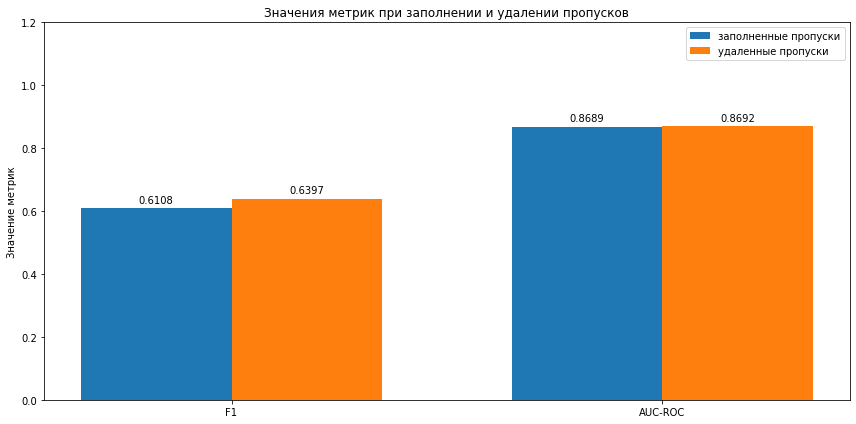

In [58]:
labels = ['F1', 'AUC-ROC']

y_test_1 = [f1_rf_b_test, auc_roc_rf_b_test]
y_test_2 = [f1_rf_b_test_dm, auc_roc_rf_b_test_dm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, y_test_1, width, label='заполненные пропуски')
rects2 = ax.bar(x + width/2, y_test_2, width, label='удаленные пропуски')

ax.set_ylabel('Значение метрик')
ax.set_ylim(0, 1.2)
ax.set_title('Значения метрик при заполнении и удалении пропусков')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Можно сделать следующие выводы из последних трех графиков:
 * На валидационной выборке значения метрик падают при удалении пропусков из данных;
 * На тестовой выборке значения метрик растут при удалении пропусков;
 * F1-мера более чувствительна к удалению пропусков, в отличие от AUC-ROC.

<a id='9'></a>

## 9. Вывод<div align=right>[To top](#top)</div>

В соответствии с заданием создали несколько моделей чтобы решить поставленную задачу прогноза оттока клиентов.

В результате испытаний определили, что наиболее подходящей моделью, в нашем случае, является модель "Случайный лес" с гиперпараметрами максимальная глубина дерева 7 и количеством деревьев 61 при условии удаления пропусков из данных. F1-мера составила **0,64**.

Перед обучением модели провели подготовку данных и признаков:
 * удалили пропуски,
 * удалили не играющие роли в обучении признаки,
 * закодировали категориальные признаки one-hot методом с применением аргумента drop_first,
 * масштабировали непрерывные признаки методом стандартизации StandartScaler